# Melanoma Dataset EDA Light

Sources:
    
- https://www.kaggle.com/code/andradaolteanu/siim-melanoma-competition-eda-augmentations

In [30]:
# running interactively in kaggle or as background job in kaggle
import os
if (get_ipython().config.IPKernelApp.connection_file.startswith('/root/.local/share')
    or 'SHLVL' in os.environ):
    BASE_PATH = '/kaggle/input/'
    
else:
    BASE_PATH = '../data/'

In [31]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running on {DEVICE}')

import pathlib
import math
from typing import Union

import torch.nn as nn
import missingno as msno
import pandas as pd
from scipy.stats import pointbiserialr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pydicom
from IPython.display import HTML
import numpy as np
from skimage import measure
import copy
import torchvision
import torch.optim as optim

Running on cpu


## Load Data

In [32]:
df_train = pd.read_csv(BASE_PATH+'siim-isic-melanoma-classification/train.csv')
df_test = pd.read_csv(BASE_PATH+'siim-isic-melanoma-classification/test.csv')

In [33]:
df_train

image_name  patient_id     sex  age_approx  \
0      ISIC_2637011  IP_7279968    male        45.0   
1      ISIC_0015719  IP_3075186  female        45.0   
2      ISIC_0052212  IP_2842074  female        50.0   
3      ISIC_0068279  IP_6890425  female        45.0   
4      ISIC_0074268  IP_8723313  female        55.0   
...             ...         ...     ...         ...   
33121  ISIC_9999134  IP_6526534    male        50.0   
33122  ISIC_9999320  IP_3650745    male        65.0   
33123  ISIC_9999515  IP_2026598    male        20.0   
33124  ISIC_9999666  IP_7702038    male        50.0   
33125  ISIC_9999806  IP_0046310    male        45.0   

      anatom_site_general_challenge diagnosis benign_malignant  target  
0                         head/neck   unknown           benign       0  
1                   upper extremity   unknown           benign       0  
2                   lower extremity     nevus           benign       0  
3                         head/neck   unknown           benign       0  
4                   upper extremity   unknown           benign       0  
...                             ...       ...              ...     ...  
33121                         torso   unknown           benign       0  
33122                         torso   unknown           benign       0  
33123               lower extremity   unknown           benign       0  
33124               lower extremity   unknown           benign       0  
33125                         torso     nevus           benign       0  

[33126 rows x 8 columns]

In [34]:
df_train.nunique()

image_name                       33126
patient_id                        2056
sex                                  2
age_approx                          18
anatom_site_general_challenge        6
diagnosis                            9
benign_malignant                     2
target                               2
dtype: int64

## Missing Data

In [35]:
ser_perc = (df_train.isnull().sum() / len(df_train)).round(decimals=3)
pd.concat((df_train.isnull().sum(), 
           ser_perc), 
          axis=1)

0      1
image_name                       0  0.000
patient_id                       0  0.000
sex                             65  0.002
age_approx                      68  0.002
anatom_site_general_challenge  527  0.016
diagnosis                        0  0.000
benign_malignant                 0  0.000
target                           0  0.000

C:\Users\Johannes\AppData\Local\pypoetry\Cache\virtualenvs\notebooks-JGOOFdU--py3.11\Lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(
C:\Users\Johannes\AppData\Local\pypoetry\Cache\virtualenvs\notebooks-JGOOFdU--py3.11\Lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


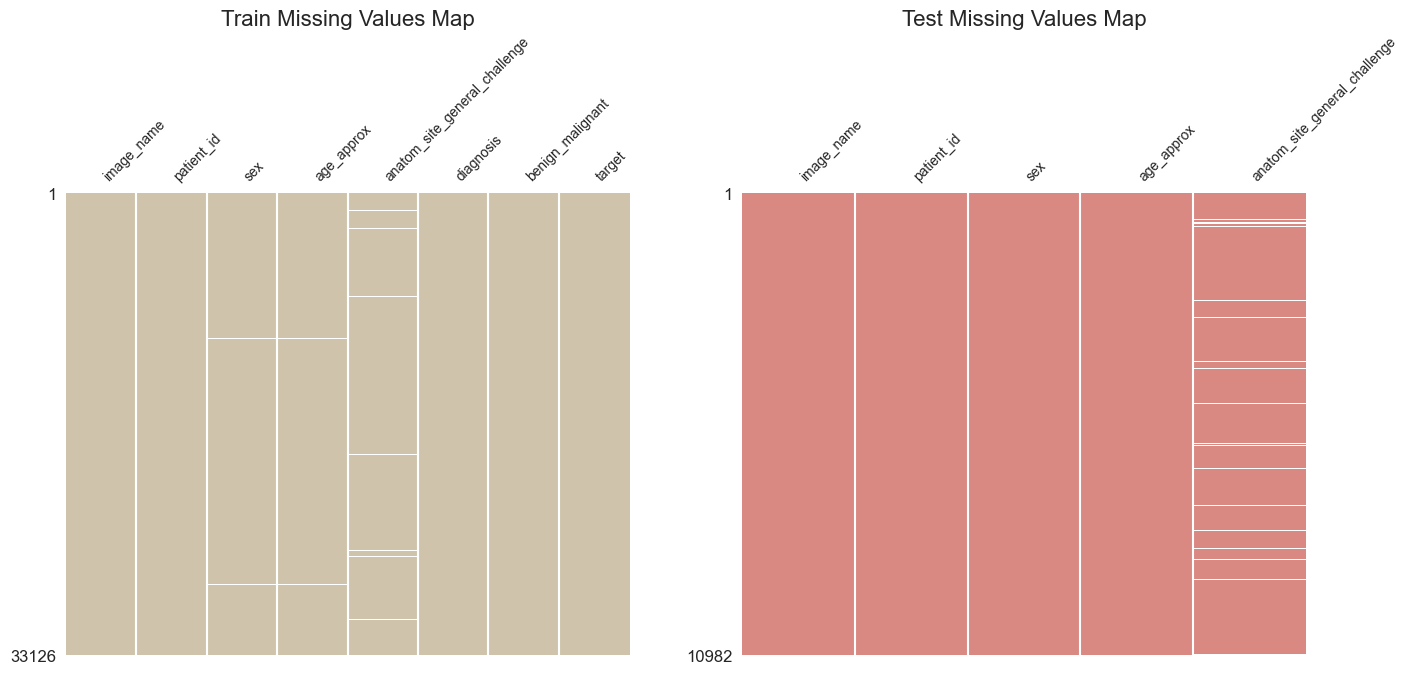

In [36]:
fig, (ax1, ax2) = plt.subplots(nrows=1, 
                               ncols=2, 
                               figsize = (16, 6))

msno.matrix(df_train, ax=ax1, color=(207/255, 196/255, 171/255), fontsize=10)
msno.matrix(df_test, ax=ax2, color=(218/255, 136/255, 130/255), fontsize=10)

ax1.set_title('Train Missing Values Map', fontsize = 16)
ax2.set_title('Test Missing Values Map', fontsize = 16);


## Labels

<Axes: ylabel='count'>

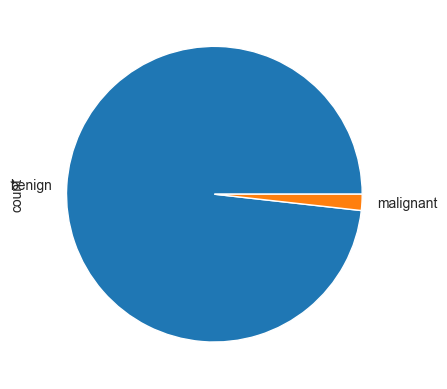

In [37]:
df_train['benign_malignant'].value_counts().plot(kind='pie')

## Features

6


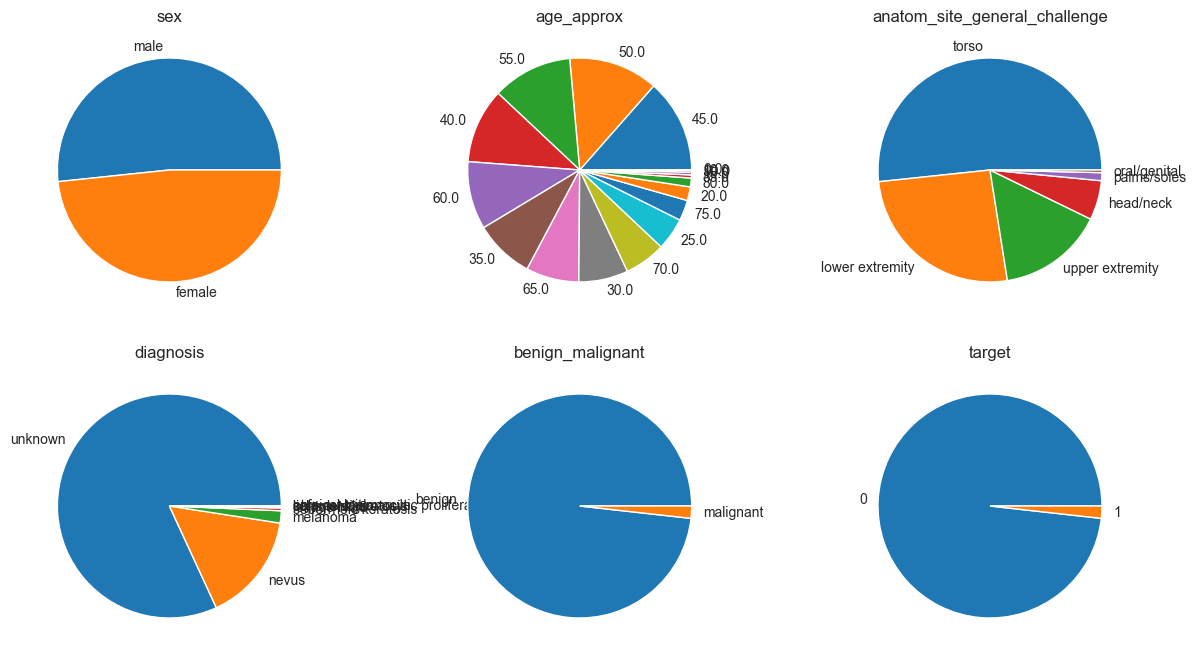

In [38]:
columns = df_train.columns[2:]
print(len(columns))

fig, axes = plt.subplots(nrows=math.ceil(len(columns)/3), 
                         ncols=3,
                         figsize=(15, 8))
axes = axes.flatten()

for idx, column in enumerate(columns):
    ax = axes[idx]
    sizes = df_train[column].value_counts().to_dict()
    ax.pie(sizes.values(), 
           labels=sizes.keys(),
           # colors=['g', 'orange', 'r'])
          )
    ax.set_title(column)
    
for ax in axes:
    ax.set_axis_off()
plt.show()

C:\Users\Johannes\AppData\Local\pypoetry\Cache\virtualenvs\notebooks-JGOOFdU--py3.11\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Johannes\AppData\Local\pypoetry\Cache\virtualenvs\notebooks-JGOOFdU--py3.11\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Johannes\AppData\Local\pypoetry\Cache\virtualenvs\notebooks-JGOOFdU--py3.11\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Johannes\AppData\Local\pypoetry\Cache\virtu

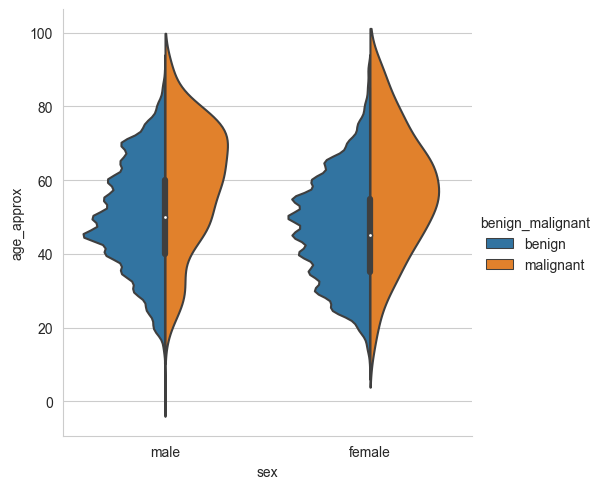

In [39]:
sns.catplot(
    data=df_train, x="sex", y="age_approx", hue="benign_malignant",
    kind="violin", split=True,
)

C:\Users\Johannes\AppData\Local\pypoetry\Cache\virtualenvs\notebooks-JGOOFdU--py3.11\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Johannes\AppData\Local\pypoetry\Cache\virtualenvs\notebooks-JGOOFdU--py3.11\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Johannes\AppData\Local\pypoetry\Cache\virtualenvs\notebooks-JGOOFdU--py3.11\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Johannes\AppData\Local\pypoetry\Cache\virtu

<Axes: xlabel='anatom_site_general_challenge', ylabel='age_approx'>

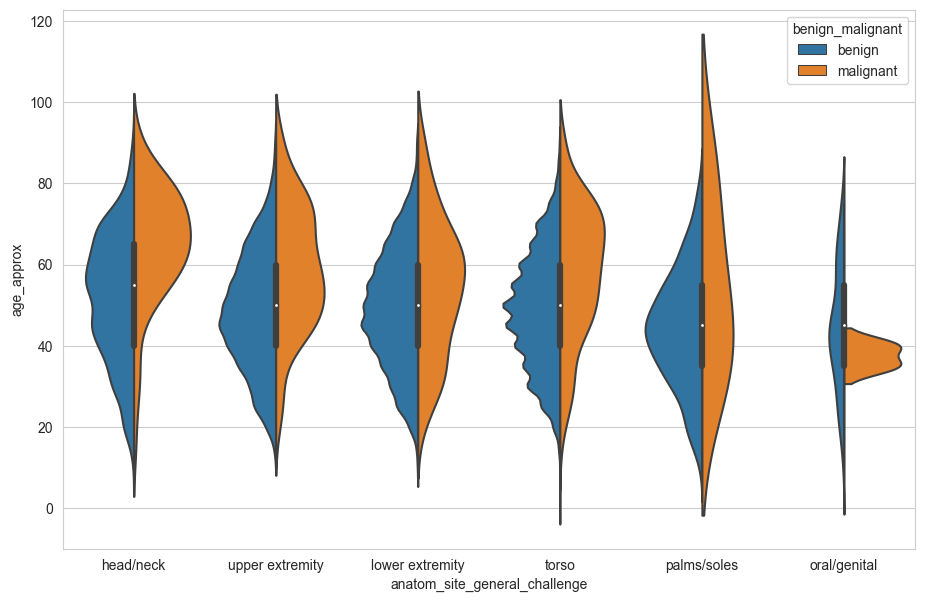

In [40]:

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(11, 7))

sns.violinplot(
    data=df_train, x="anatom_site_general_challenge", y="age_approx", hue="benign_malignant",
    kind="violin", split=True, ax=ax
)

C:\Users\Johannes\AppData\Local\pypoetry\Cache\virtualenvs\notebooks-JGOOFdU--py3.11\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Johannes\AppData\Local\pypoetry\Cache\virtualenvs\notebooks-JGOOFdU--py3.11\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='age_approx', ylabel='Count'>

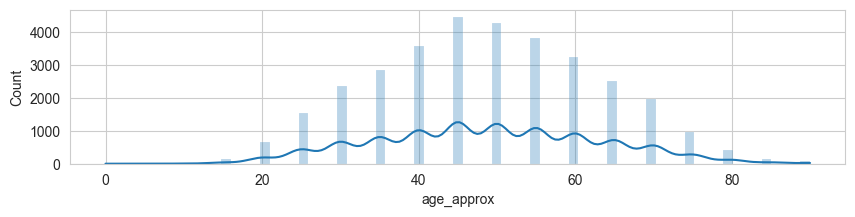

In [41]:
fig = plt.figure(figsize=(10, 2))
sns.histplot(df_train['age_approx'], 
             kde=True, 
             linewidth=0.1, 
             ax=plt.gca(), 
             alpha=0.3)

# Preview Images

In [42]:
df_train

image_name  patient_id     sex  age_approx  \
0      ISIC_2637011  IP_7279968    male        45.0   
1      ISIC_0015719  IP_3075186  female        45.0   
2      ISIC_0052212  IP_2842074  female        50.0   
3      ISIC_0068279  IP_6890425  female        45.0   
4      ISIC_0074268  IP_8723313  female        55.0   
...             ...         ...     ...         ...   
33121  ISIC_9999134  IP_6526534    male        50.0   
33122  ISIC_9999320  IP_3650745    male        65.0   
33123  ISIC_9999515  IP_2026598    male        20.0   
33124  ISIC_9999666  IP_7702038    male        50.0   
33125  ISIC_9999806  IP_0046310    male        45.0   

      anatom_site_general_challenge diagnosis benign_malignant  target  
0                         head/neck   unknown           benign       0  
1                   upper extremity   unknown           benign       0  
2                   lower extremity     nevus           benign       0  
3                         head/neck   unknown           benign       0  
4                   upper extremity   unknown           benign       0  
...                             ...       ...              ...     ...  
33121                         torso   unknown           benign       0  
33122                         torso   unknown           benign       0  
33123               lower extremity   unknown           benign       0  
33124               lower extremity   unknown           benign       0  
33125                         torso     nevus           benign       0  

[33126 rows x 8 columns]

In [43]:
path_train_dicom = pathlib.Path(BASE_PATH+'siim-isic-melanoma-classification/train/')
path_train_jpeg = pathlib.Path(BASE_PATH+'siim-isic-melanoma-classification/jpeg/train/')

print(len(list(path_train_dicom.iterdir())))
print(len(list(path_train_jpeg.iterdir())))


# There's a .dcm dataset and a .jpg image for each train.csv entry

5
5


In [44]:
def plot_images(images: Union[np.array, list[np.array]], title='', cmap='gray'):  # (n, width, length)
    
    n_cols = 5
    n_rows = math.ceil(len(images)/n_cols)
    
    fig, axes = plt.subplots(nrows=n_rows, 
                             ncols=n_cols,
                             figsize=(n_cols*6, n_rows*6))
    axes = axes.flatten()
    
    for i, image in enumerate(images):  # image: (width, length)
        ax = axes[i]
        ax.imshow(X=image,
                  cmap=cmap)  # plt.cm.bone
        ax.set_xticks([])
        ax.set_yticks([])
        
    if title:
        plt.suptitle(title, fontsize=30)
    
    plt.tight_layout()
    plt.show()

## Plot random DICOM vs JPEG

C:\Users\Johannes\AppData\Local\pypoetry\Cache\virtualenvs\notebooks-JGOOFdU--py3.11\Lib\site-packages\pydicom\valuerep.py:443: UserWarning: Invalid value for VR UI: '"1.2.840.10008.5.1.4.1.1.77.1.4"'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


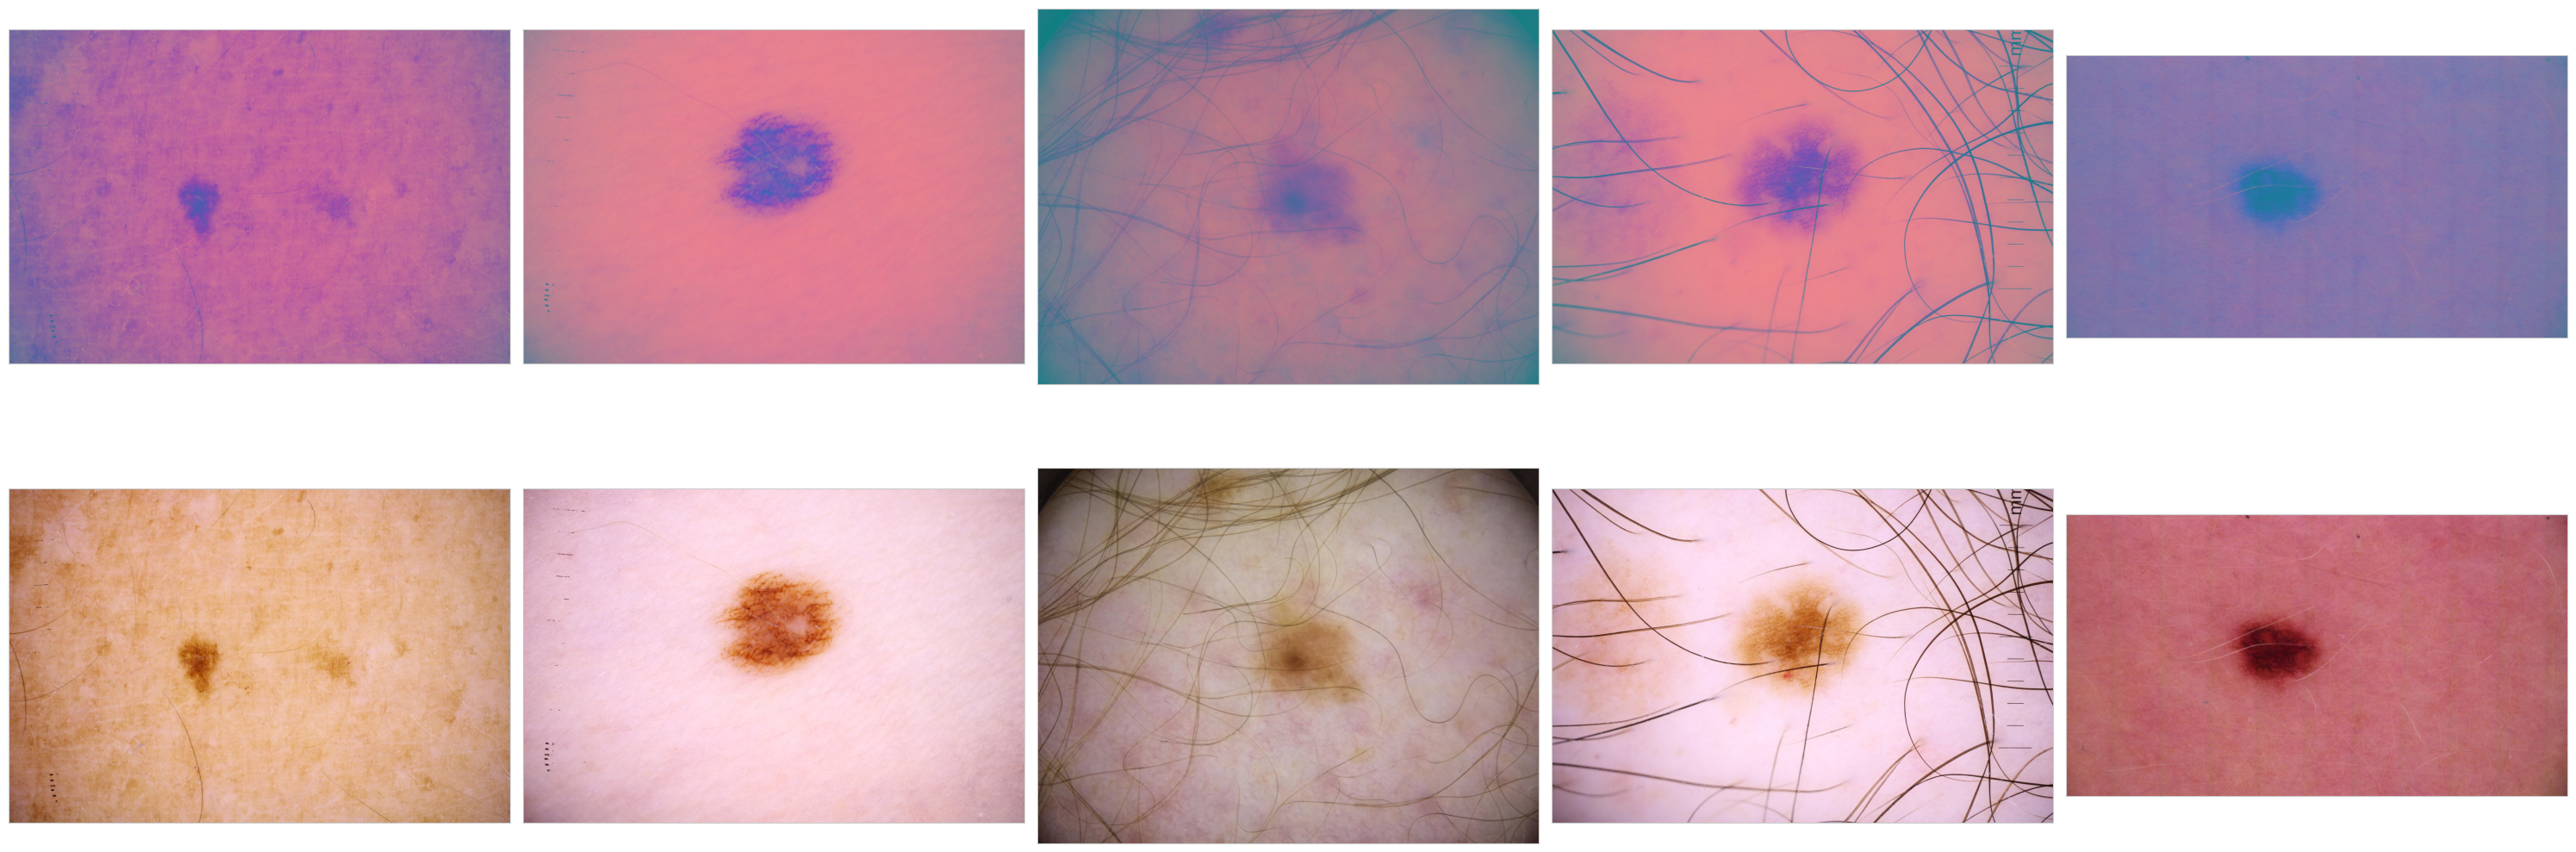

In [45]:
#image_names = df_train.sample(frac=1).iloc[:5]['image_name']
image_names=['ISIC_0015719',
             'ISIC_0074311',
             'ISIC_0078712',
             'ISIC_0083035',
             'ISIC_0084395']

image_paths_dicom = [f'{BASE_PATH}siim-isic-melanoma-classification/train/{image_name}.dcm' for image_name in image_names]
images_dicom = [pydicom.dcmread(image_path).pixel_array for image_path in image_paths_dicom]

image_paths_jpeg = [f'{BASE_PATH}siim-isic-melanoma-classification/jpeg/train/{image_name}.jpg' for image_name in image_names]
images_jpeg = [plt.imread(image_path) for image_path in image_paths_jpeg]

plot_images(images_dicom + images_jpeg)

## Plot Random Benign and Malignant Lesions

In [46]:
image_names = df_train[df_train['benign_malignant'] == 'benign'].sample(frac=1).iloc[:5]['image_name']

image_paths = [f'/kaggle/input/siim-isic-melanoma-classification/jpeg/train/{image_name}.jpg' for image_name in image_names]
images = [plt.imread(image_path) for image_path in image_paths]

plot_images(images, title='Random Benign Lesions')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/siim-isic-melanoma-classification/jpeg/train/ISIC_5537985.jpg'

In [ ]:
image_names = df_train[df_train['benign_malignant'] == 'malignant'].sample(frac=1).iloc[:5]['image_name']

image_paths = [f'/kaggle/input/siim-isic-melanoma-classification/jpeg/train/{image_name}.jpg' for image_name in image_names]
images = [plt.imread(image_path) for image_path in image_paths]

plot_images(images, title='Random Malignant Lesions')